In [19]:
import os
import cv2
import json
import math
import torch
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import tensorflow as tf
import torch.optim as optim
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from torchvision import transforms
import torch.nn.functional as nnf
import torchvision
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn, fasterrcnn_resnet50_fpn_v2






device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [20]:
train_batch_size = 4
test_batch_size = 1
    
lr = 0.0005
weight_decay = 1e-4
    
epochs = 40

In [21]:
train_img_path = '../../data/coco/train'
train_label_file = '../../data/coco/train/_annotations.coco.json'
test_img_path = '../../data/coco/test'
test_label_file = '../../data/coco/test/_annotations.coco.json'
valid_img_path = '../../data/coco/valid'
valid_label_file = '../../data/coco/valid/_annotations.coco.json'


In [22]:
with open(train_label_file) as json_file:
    train_data_dict = json.load(json_file)
    
with open(test_label_file) as json_file:
    test_data_dict = json.load(json_file)

with open(valid_label_file) as json_file:
    valid_data_dict = json.load(json_file)

train_data_dict['annotations'][0]

{'id': 0,
 'image_id': 0,
 'category_id': 2,
 'bbox': [226, 268, 61.875, 103.875],
 'area': 6427.265625,
 'segmentation': [],
 'iscrowd': 0}

In [23]:
cat_mapping = dict() # Variable that maps class id -> class name
for category in train_data_dict['categories']:
    cat_mapping[category['id']] = category['name']

In [24]:
class Compose(object):
    def __init__(self, transforms):

        self.transforms = transforms

    def __call__(self, image, bboxes):

        for t in self.transforms:
            image, bboxes = t(image, bboxes)
        return image, bboxes

    
class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):

        self.p = p

    def __call__(self, image, bboxes):

        if random.random() < self.p:
            image = F.hflip(image)
            width, _ = image.size
            if len(bboxes)!=0:
                bboxes = bboxes.clone()
                bboxes[:, [0, 2]] = width - bboxes[:, [2, 0]]  # Flip x_min and x_max
        return image, bboxes

    
class ToTensor(object):
    def __call__(self, image, bboxes):

        image = F.to_tensor(image)
        return image, bboxes

In [25]:
train_transform = Compose([
            RandomHorizontalFlip(p=0.5),
            ToTensor()
        ])

val_transform = Compose([
            ToTensor()
        ])

test_transform = val_transform

In [26]:
class CSGO_Dataset(Dataset):
    def __init__(self, img_path, data_dict, transform=None):

        self.img_path = img_path
        self.data_dict = data_dict
        self.transform = transform
        self.dataset = self.create_dataset()
    
    def create_dataset(self):

        dataset = []
        for element in self.data_dict["images"]:
            img_id = element['id']
            img_annotations = []
            for annotation in self.data_dict['annotations']:
                if annotation['image_id'] == img_id:
                    img_annotations.append(annotation)
            dataset.append([element['file_name'], img_annotations])
        
        return dataset
    
    def __len__(self):

        return len(self.data_dict['images'])
    
    def collate_fn(self, batch):

        images = list()
        boxes = list()
        labels = list()
        areas = list()
        image_id = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
            areas.append(b[3])
            image_id.append(b[4])

        images = torch.stack(images, dim=0)

        return images, boxes, labels, areas, image_id
    
    def __getitem__(self, idx):

        
        img = cv2.imread(os.path.join(self.img_path, self.dataset[idx][0]))            
        cat_ids = []
        bbs = []
        areas = []
        iscrowd = []
        image_id = []
        for annotation in self.dataset[idx][1]:
            cat_ids.append(annotation['category_id'])
            bbs.append(annotation['bbox'])
            areas.append(annotation['area'])
            iscrowd.append(annotation['iscrowd'])
            image_id.append(annotation['image_id'])
        cat_ids = torch.Tensor(cat_ids)
        
        areas = torch.Tensor(areas)
        iscrowd = torch.Tensor(iscrowd)
        image_id = torch.Tensor(image_id)
        
        bbs = np.array(bbs)
        for i, bb in enumerate(bbs):
            x_min, y_min, width, height = bb
            x1, y1 = x_min, y_min
            x2, y2 = x_min + width, y_min + height
            bbs[i] = np.array([x1, y1, x2, y2])
        
        bbs = torch.Tensor(bbs)
        if self.transform:
            img = Image.fromarray(img)
            img, bbs = self.transform(img, bbs)
        
        bbs = torch.from_numpy(np.array(bbs))
        cat_ids = torch.Tensor(cat_ids).long()
        
        return img, bbs, cat_ids, areas, image_id

In [27]:
train_dataset = CSGO_Dataset(train_img_path, train_data_dict, transform=train_transform)
test_dataset = CSGO_Dataset(test_img_path, test_data_dict, transform=test_transform)
valid_dataset = CSGO_Dataset(valid_img_path, valid_data_dict, transform=test_transform)

In [28]:
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, collate_fn=test_dataset.collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=test_batch_size, shuffle=False, collate_fn=valid_dataset.collate_fn)

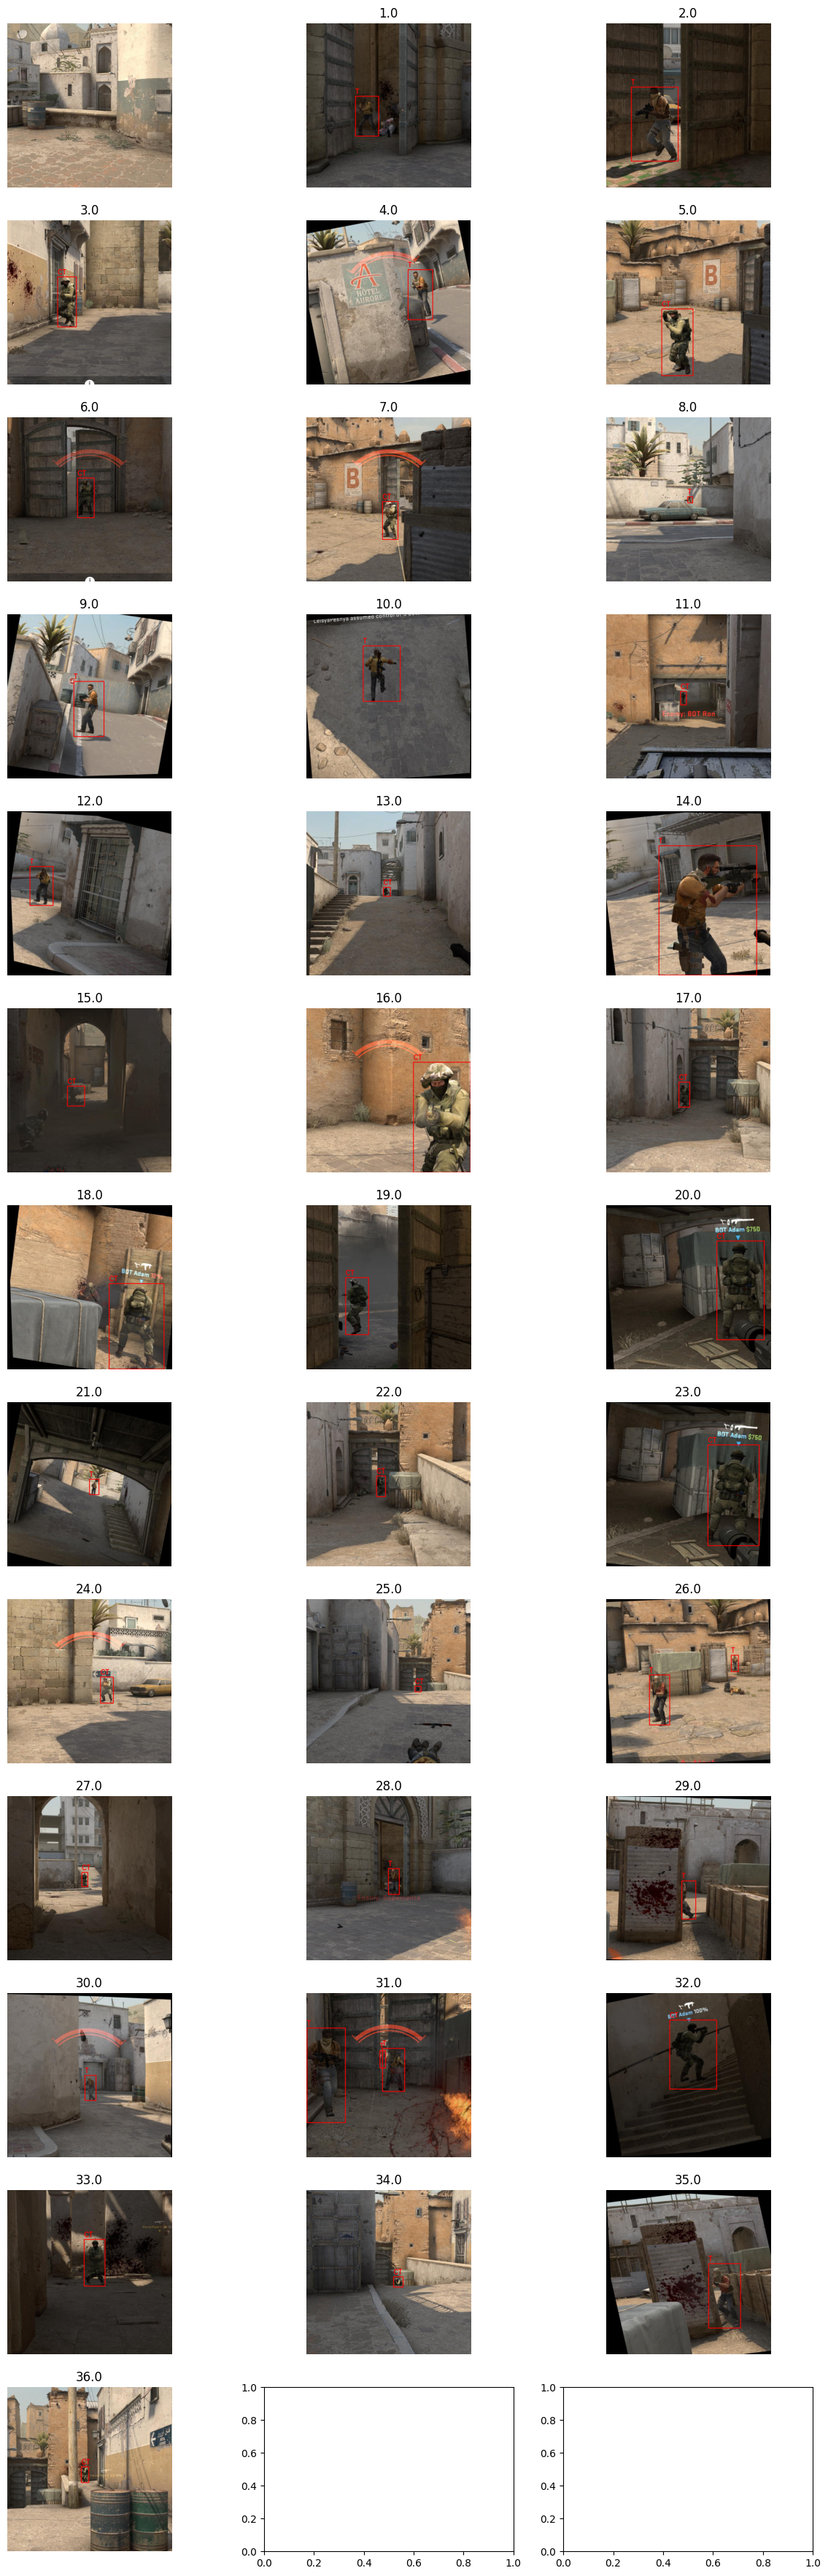

In [29]:
def plot_images_with_boxes(images, bbs, labels, image_id, class_names, ax, i, columns):

    for img, bb, lbl, img_id in zip(images, bbs, labels, image_id):
        img = img.permute(1, 2, 0).cpu().numpy()
        img = (img * 255).astype(np.uint8) # Convert image from [0, 1] to [0, 255] range
        
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Convert from RGB (Matplotlib) to BGR (OpenCV)       
        
        for box, label in zip(bb, lbl): # For each bounding box and label found in the image
            x1, y1, x2, y2 = map(int, box) # Convert Tensor values in box to integers
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)  # Draw bounding box
            cv2.putText(img, class_names[int(label)], org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.9, color=(255, 0, 0), thickness=2)  # Draw class label

        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert back to RGB for plotting
        ax[i//columns][i%columns].imshow(img)
        ax[i//columns][i%columns].axis("off")
        if(len(img_id) > 0):
            ax[i//columns][i%columns].set_title(f"{img_id[0]}")

rows = math.ceil(len(test_dataloader)/3)
columns = 3
fig, ax = plt.subplots(rows, columns, figsize=(15, 45))
for i, (images, bbs, labels, areas, image_id) in enumerate(test_dataloader):
    plot_images_with_boxes(images, bbs, labels, image_id, cat_mapping, ax, i, columns)
plt.show()

In [30]:
class_frequencies = {cat_mapping[k]:0 for k,v in cat_mapping.items()}

for annotation in train_data_dict['annotations']:
    category_id = annotation['category_id']
    category_name = cat_mapping[category_id]
    class_frequencies[category_name] = class_frequencies[category_name] + 1

classes = list(class_frequencies.keys())
frequencies = list(class_frequencies.values())

fig = go.Figure(data=[go.Bar(x=classes, y=frequencies)])
fig.update_layout(
    title='Class Frequency Histogram',
    xaxis_title='Class Names',
    yaxis_title='Frequency',
    template='seaborn'
)

fig.show()

In [31]:
def get_model(num_classes, pretrained=False):

    model = fasterrcnn_resnet50_fpn(pretrained=pretrained)

    # Freezing backbone parameters
    if pretrained:
        for param in model.backbone.parameters():
            param.requires_grad = False

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


In [32]:

def calculate_iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    inter_min_x = max(x1_min, x2_min)
    inter_min_y = max(y1_min, y2_min)
    inter_max_x = min(x1_max, x2_max)
    inter_max_y = min(y1_max, y2_max)

    inter_area = max(0, inter_max_x - inter_min_x) * max(0, inter_max_y - inter_min_y)

    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou

def get_valid_acc(model, valid_loader, iou_threshold=0.5):
    model.eval()  # Set model to evaluation mode
    total_images = 0
    total_correct = 0
    
    with torch.no_grad():  # Disable gradient computation
        for images, bbs, labels, areas, image_id in valid_loader:
            images = list(image.to(device) for image in images)
            bbs = [bb.to(device) for bb in bbs]
            labels = [label.to(device) for label in labels]

            outputs = model(images)
            
            for i, output in enumerate(outputs):
                preds = output['boxes'].cpu().numpy()
                pred_labels = output['labels'].cpu().numpy()
                
                true_boxes = bbs[i].cpu().numpy()
                true_labels = labels[i].cpu().numpy()

                matched = 0
                for pred_box, pred_label in zip(preds, pred_labels):
                    for true_box, true_label in zip(true_boxes, true_labels):
                        if pred_label == true_label:
                            iou = calculate_iou(pred_box, true_box)
                            if iou >= iou_threshold:
                                matched += 1
                                break

                total_images += 1
                total_correct += matched / len(true_boxes)

    validation_accuracy = total_correct / total_images
    return validation_accuracy

In [33]:
def plot_test_predictions(image, boxes, labels, scores, class_names, true_boxes, true_labels, image_id, iou_threshold=0.7):

    image = image.permute(1, 2, 0).numpy()
    image = (image * 255).astype(np.uint8) # Convert back to [0, 255] range
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    for box, label, score in zip(boxes, labels, scores): # For each bounding box and label found in the image
        x1, y1, x2, y2 = map(int, box)
        match = False
        match_bb = False
        for true_box, true_label in zip(true_boxes, true_labels):
            if calculate_iou(box, true_box) >= iou_threshold and label == true_label: # Bounding Box and class right
                match = True
            elif calculate_iou(box, true_box) >= iou_threshold: # Bounding Box right but class wrong
                match_bb = True
        
        text = f'{class_names[int(label)]}: {score:.2f}'
        if match:
            green = (0, 255, 0)
            cv2.rectangle(image, (x1, y1), (x2, y2), color=green, thickness=2)
            cv2.putText(image, text, org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.9, color=green, thickness=2)
        elif match_bb:
            blue = (0, 0, 255)
            cv2.rectangle(image, (x1, y1), (x2, y2), color=blue, thickness=2)
            cv2.putText(image, text, org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.9, color=blue, thickness=2)
        else:
            red = (255, 0, 0)
            cv2.rectangle(image, (x1, y1), (x2, y2), color=red, thickness=2)
            cv2.putText(image, text, org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.9, color=red, thickness=2)

    plt.title(f'Image {int(image_id[0])}')
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [34]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, epoch, valid_loader):
    model.train()
    
    i = 0
    total_train_loss = 0
    loss_classifier = 0
    loss_box_reg = 0
    loss_objectness = 0
    loss_rpn_box_reg = 0
    total_samples = 0
    total_accuracy = 0
    for images, bbs, labels, areas, image_id in dataloader:
        #Redundancy train which will almost never run unless some sort of error happens
        #But keeping it here for security purposes so it does not cancel code on some epoch
        model.train()
        images = images.float().to(device)
        targets = [{'boxes':bbs[i].to(device), 'labels':labels[i].to(device)} for i, bb in enumerate(bbs)]
        optimizer.zero_grad()
        if 0 in list(map(len, bbs)):
            continue
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        losses.backward()
        optimizer.step()

        total_train_loss += losses.item() * images.size(0)
        loss_classifier += loss_dict['loss_classifier'].item() * images.size(0)
        loss_box_reg += loss_dict['loss_box_reg'].item() * images.size(0)
        total_samples += images.size(0)
        i += 1
    average_train_loss = total_train_loss / total_samples
    average_classifier_loss = loss_classifier / total_samples
    average_box_reg_loss = loss_box_reg / total_samples
    validation_accuracy = get_valid_acc(model, valid_loader)
    lr_scheduler.step()
    print(f"Epoch {epoch + 1}, Total Loss: {average_train_loss:.4f}, Class. Loss: {average_classifier_loss:.4f}, Accuracy_valid: {validation_accuracy * 100}", end='\r')
    return average_train_loss, average_classifier_loss, average_box_reg_loss, validation_accuracy

In [35]:
num_classes = len(cat_mapping.keys())  # Number of classes including background
model = get_model(num_classes, pretrained=True).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=epochs//2, gamma=0.1)

In [36]:
import sys
print(device)
model.train()
# Training loop
train_losses = []
valid_accuracy = []
for epoch in range(epochs):
    epc_train_loss, epc_class_loss, epc_box_reg_loss, validation_accuracy = train_epoch(model, train_dataloader, optimizer, lr_scheduler, epoch, valid_dataloader)
    sys.stdout.write(f"\rEpoch {epoch + 1} Total Loss: {epc_train_loss:.4f} Class. Loss: {epc_class_loss:.4f}\n")
    sys.stdout.flush()
    train_losses.append(epc_train_loss)
    valid_accuracy.append(validation_accuracy * 100)
max_loss = max(train_losses)

epochs = range(1, len(valid_accuracy) + 1)


plt.figure(figsize=(10, 5))
plt.plot(epochs, valid_accuracy, label='Validation Accuracy %', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training loss', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
upperLimy = max_loss + .1 * max_loss
plt.ylim(bottom=0, top = upperLimy)
plt.show()

cuda


ZeroDivisionError: division by zero

In [ ]:
checkpoint_path = 'pretrained_40.pth'

# Save the model state dictionary and optimizer state dictionary
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, checkpoint_path)

print(f"Model checkpoint saved to {checkpoint_path}")